In [15]:
import pandas as pd
import numpy as np
import re #Regex lib
from forex_python.converter import CurrencyRates #currencies lib
from datetime import datetime
import matplotlib

### Read in the dataframes and create a dict {(year, dataframe)}


In [16]:
# Create a list of filenames for the datasets
years = [2011,2012,2013,2014,2015,2016,2017, 2018, 2019, 2020, 2021]
file_names = ['datasets/{}.csv'.format(year) for year in years]

# Read in the dataframes and create a dict {(year, dataframe)}
data_frames = [pd.read_csv(file_name, encoding = "ISO-8859-1") for file_name in file_names]
data_frames_dict = {}

for year, df in zip (years,data_frames):
    data_frames_dict[year] = df

# Section 1: Salary preprocessing

### The following currencies were found in the datasets and could not be converted to their equivalent currency symbols

In [17]:
currency_dict = {'Australian dollars (A$)': 'AUD',
 'Bitcoin (btc)': 'btc',
 'Brazilian reais (R$)': 'BRL',
 'British pounds sterling (Â£)': 'GBP',
 'Canadian dollars (C$)': 'CAD',
 'Chinese yuan renminbi (Â¥)': 'CNY',
 'Euros (â\x82¬)': 'EUR',
 'Indian rupees (?)': 'INR',
 'Japanese yen (Â¥)': 'JPY',
 'Polish zloty (zl)': 'PLN',
 'Russian rubles (?)': 'RUB',
 'Singapore dollars (S$)': 'SGD',
 'South African rands (R)': 'ZAR',
 'Swiss francs': 'CHF',
 'U.S. dollars ($)': 'USD',
 'none\tCook Islands dollar': 'NZD'}

### Compute currency symbols and add them to the 'currency_dict'

In [18]:
#helper function to covert currency to its symbol 
def add_currencies_to_dict(currency, currency_dict):
        currency_symbol = re.findall(r'[ˆA-Z]{3}', currency )

        if currency_symbol:
            # redundnat to add symbol to a dict {symbol -> symbol}but helps to treat all currencies the same
            currency_dict[currency] = currency_symbol[0]
        else:
            if currency not in currency_dict:
                print("WARN: there is no conversion available for this currency {}".format(currency))


# go through the  'CurrencySymbol' column if exists, otherwise 'Currency' 
# add all currencies that are not NaN to the 'currency_dict'
for year , df in data_frames_dict.items():
    
    # Check if Currecny column is present in df
    if 'CurrencySymbol' in df:
        print("{} year dataframe has a 'CurrencySymbol' column ".format(year))
        for currency_symbol in df.CurrencySymbol:
            #check for NaN
            if not pd.isna(currency_symbol):
                # redundnat to add symbol to a dict {symbol -> symbol}but helps to treat all currencies the same
                currency_dict[currency_symbol] = currency_symbol
    elif 'Currency' in df:
        print("{} year dataframe has a 'Currency' column ".format(year))
        for currency in df.Currency:
            #check for NaN
            if not pd.isna(currency):
                # add to dict {currency -> currency_symbol}
                add_currencies_to_dict(currency, currency_dict)   
                

2017 year dataframe has a 'Currency' column 
2018 year dataframe has a 'CurrencySymbol' column 
2019 year dataframe has a 'CurrencySymbol' column 
2020 year dataframe has a 'CurrencySymbol' column 
2021 year dataframe has a 'Currency' column 


### Preporcess the salary related columns (currency, salary, salary type etc ) for datasets

#### Auxilliary/helper methods for currency conversions

In [19]:

def convert_currency(amount, currency, factor):
    return available_currencies_for_conversion[currency] * amount * factor


currency_converter = CurrencyRates()
date = datetime(2017, 12, 31, 18, 36, 28, 151012)

available_currencies_for_conversion = currency_converter.get_rates('EUR', date)

available_currencies_for_conversion['EUR']  = 1

# Take care of outlier salaries 
# max montly income in euros
max_montly_salary = 20000

# minimum mothly income in euros
min_montly_salary = 0

In [20]:
#Dictionary to hold processed payments/salary dataframes for yeas 2017 - 2021

clean_payment_dataframes_2017_to_2020 ={}

### Process 2017 payments

In [21]:
df_2017 = data_frames_dict[2017]

# annual salary divide by 12
annual_rate = float (1/12)

# select only currency and salary columns 
payment_df_2017= df_2017.filter(items=['Country', 'Currency',  'Salary'])

#Remove all raws with a NaN
clean_payment_df_2017 = payment_df_2017.dropna(thresh=3)


# for each currency entry, replace it with its currency symbol
clean_payment_df_2017.Currency = clean_payment_df_2017.Currency.apply(lambda x: currency_dict[x])


# Filter out the currencies that we cannot convert
clean_payment_df_2017 = clean_payment_df_2017[clean_payment_df_2017.Currency.apply(lambda c:   c  in available_currencies_for_conversion)]
    
# Covert salary to a euros and divide it by 12  
clean_payment_df_2017['Monthly_Sal_EUR'] = clean_payment_df_2017.apply(lambda row : convert_currency(row['Salary'],
                     row['Currency'], annual_rate), axis = 1)

# drop Currency, Salary columns 
# drop c salaries less than min_salary and greater than max salary 
clean_payment_df_2017 = clean_payment_df_2017.drop(['Currency','Salary' ], axis=1)
clean_payment_df_2017 = clean_payment_df_2017[(clean_payment_df_2017.Monthly_Sal_EUR > min_montly_salary) & (clean_payment_df_2017.Monthly_Sal_EUR < max_montly_salary)]

clean_payment_dataframes_2017_to_2020[2017] = clean_payment_df_2017

### Process 2018 payments

In [22]:
df_2018 = data_frames_dict[2018]

# we are only interested in two columns here
payment_df_2018= df_2018.filter(items=['Country',  'ConvertedSalary'])

#Remove all raws with a NaN and all rows the ConvertedSalary = 0.00
clean_payment_df_2018 = payment_df_2018.dropna(thresh=2) 


# convert the converted annual USD salary to monthly salary 
clean_payment_df_2018['Monthly_Sal_EUR'] = clean_payment_df_2018.apply(
    lambda row : convert_currency(row['ConvertedSalary'],'USD', annual_rate), axis = 1)

# We are no longer interested in the ConvertedSalary
# Also drop outlier salaries 
clean_payment_df_2018 = clean_payment_df_2018.drop('ConvertedSalary', axis=1)[(clean_payment_df_2018.Monthly_Sal_EUR > min_montly_salary) & (clean_payment_df_2018.Monthly_Sal_EUR < max_montly_salary)]

clean_payment_dataframes_2017_to_2020[2018] = clean_payment_df_2018

/Users/pgp/opt/anaconda3/envs/Soft_Alignment/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


### Covert 2019 - 2021 - these data frames have the same salary related columns 

In [23]:
df_2019_2021 = [data_frames_dict[2019], data_frames_dict[2020], data_frames_dict[2021]]
years = [2019, 2020, 2021]

annual_rate = 1/12

# salary types
clean_payment_dfs_2019_2021 = {}
for year in years:
    df = data_frames_dict[year]

    payment_df= df.filter(items=['Country',  'CompTotal'])

    #Remove all raws with a NaN and all rows the CompTotal = 0.00
    clean_payment_df = payment_df.dropna(thresh=2)
    # convert the converted annual USD salary to monthly salary 
    clean_payment_df['Monthly_Sal_EUR'] = clean_payment_df.apply(
        lambda row : convert_currency(row['CompTotal'],'USD', annual_rate), axis = 1)
    
    # drop CompTotal column
    # Also drop outlier salaries 
    clean_payment_dfs_2019_2021[year] = clean_payment_df.drop('CompTotal', axis=1)[(clean_payment_df.Monthly_Sal_EUR > min_montly_salary) & (clean_payment_df.Monthly_Sal_EUR < max_montly_salary)]
    
clean_payment_dataframes_2017_to_2020.update(clean_payment_dfs_2019_2021)


/Users/pgp/opt/anaconda3/envs/Soft_Alignment/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Compute a summary pdf - average of montly salaries per country 

<AxesSubplot:title={'center':'Uzbekistan vs. France '}>

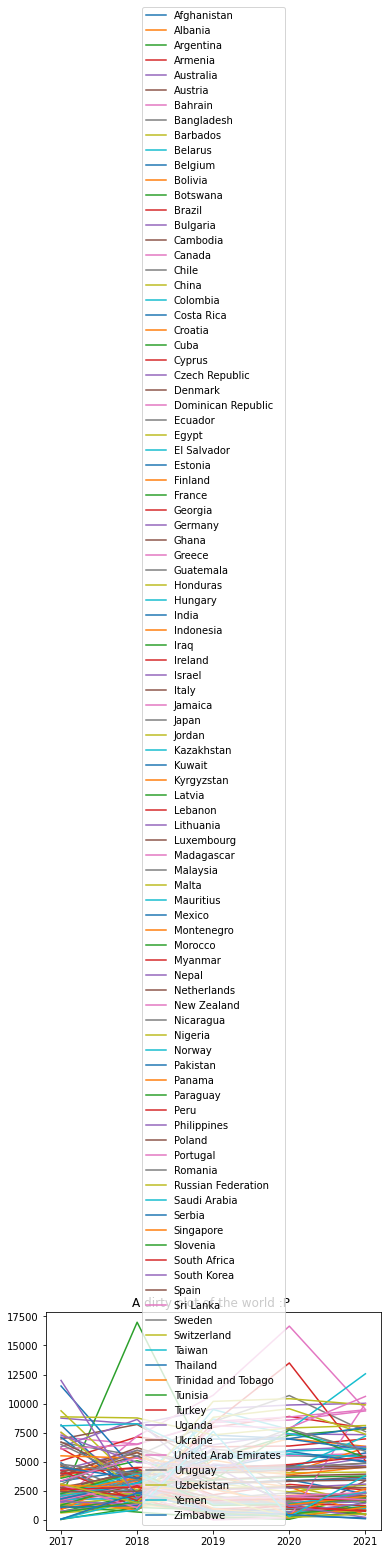

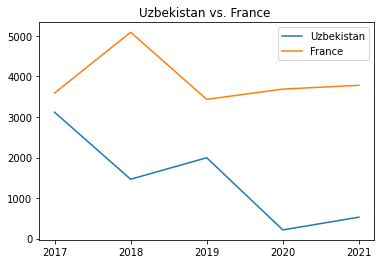

In [24]:
summary_df = None
i = 0
for year, df in clean_payment_dataframes_2017_to_2020.items():
    
    # compute mean salary per country and reset the resulting df index
    df =  df.groupby('Country').mean().reset_index()
    
    # add column names 
    df.columns = ['Country', year]
    
    # merge the resulting dataframes into a single df columns = years, rows = countries
    if i > 0:
        summary_df = pd.DataFrame.merge(summary_df,df,on='Country')
        i+=1 
    else:
        summary_df =  df
        i+=1

# Transpose the summary_df, now  columns = countries and rows = years 
summary_df = summary_df.T

# Pick all the countries -> first row of the transposed matrix
column_names = summary_df.iloc[0]
column_names = list(column_names) 

# drop the first row containing countries' names, instead make the countries the column names 
summary_df = summary_df.drop('Country')
summary_df.columns = column_names

# You can finally do some simple plots 
summary_df.plot( xticks = [2017, 2018, 2019, 2020, 2021], title= "A dirty plot of the world :P ")
summary_df[['Uzbekistan','France'] ].plot( xticks = [2017, 2018, 2019, 2020, 2021], title = "Uzbekistan vs. France ")



In [25]:
summary_df

,Afghanistan,Albania,Argentina,Armenia,Australia,Austria,Bahrain,Bangladesh,Barbados,Belarus,...,Trinidad and Tobago,Tunisia,Turkey,Uganda,Ukraine,United Arab Emirates,Uruguay,Uzbekistan,Yemen,Zimbabwe
2017,4919.02,4607,2874.35,1677.59,8756.67,3796.4,7495.62,2740.75,2998.25,2399.74,...,2998.25,669.113,2607.62,11993,2444.23,3373.18,4795.25,3118.18,99.9417,69.9592
2018,875.864,1744.91,2819.96,2425.39,8236.03,5507.23,2940.08,1521.18,1827.13,2598.53,...,2780.58,1541.18,2838.91,1860.29,2469.79,5378.03,3985.47,1464.81,869.293,2316.49
2019,4397.47,5401.56,5263.91,7972.01,9546.85,3122.71,75.1461,6088.48,349.796,487.117,...,2630.09,587.82,1682.6,6167.4,4042.79,1837.64,5412.18,1994.74,7620.55,783.709
2020,5639.8,6991.55,7289.14,8897.31,9883.8,3323.94,536.587,5510.91,417.656,481.506,...,1307.09,310.343,1806.67,1223.29,4291.12,2014.35,7838.29,214.375,299.825,473.451
2021,5071.24,6334.45,7814.44,7902.05,10027.6,3716.54,759.819,5505.88,2345.5,835.021,...,2036.99,553.77,1749.86,228.938,4518.97,1764.93,5909.9,529.021,3808.78,113.518


In [26]:
df = clean_payment_dataframes_2017_to_2020[2017]
df[df.Monthly_Sal_EUR > max_montly_salary]

,Country,Monthly_Sal_EUR
